<a href="https://colab.research.google.com/github/vshiv667/Sarcasm-Detection--LSTM/blob/master/Sarcasm_RNN_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import re

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#Load Dataset from gdrive

In [ ]:
from google.colab import drive #mount to drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls #view list of files

drive  sample_data


In [ ]:
!cp Sarcasm_Headlines_Dataset_v2.json /content/drive/Shared\ drives/NLP-project #save to google drive for future use

cp: cannot stat 'Sarcasm_Headlines_Dataset_v2.json': No such file or directory


In [ ]:
df = pd.read_json("drive/Shared drives/NLP-project/Sarcasm_Headlines_Dataset_v2.json",lines=True) #Read the file as a json object per line.
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


#Data Processing

In [ ]:
df.shape #check dimensions

(28619, 3)

In [ ]:
df.isna().sum() #check for any nulls

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [ ]:
df2 = df.iloc[:, :2] #article link is not required for analysis. All saracastic articles - TheOnion, rest are - HuffPost
df2.head(3)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes


Text(0, 0.5, 'Frequency')

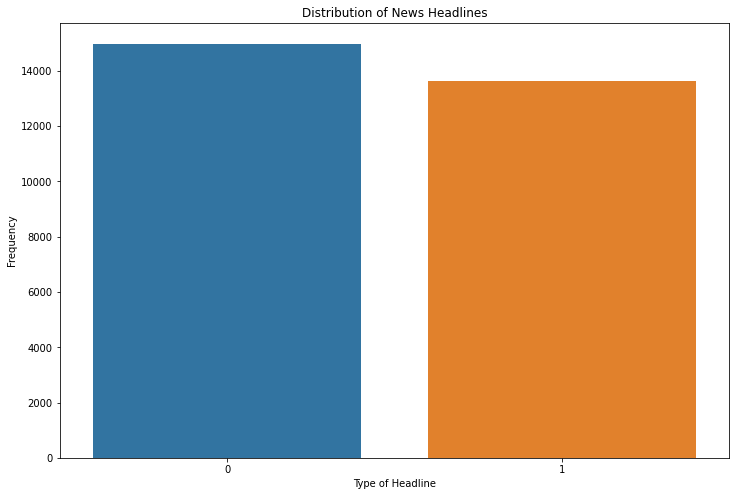

In [ ]:
plt.figure(figsize=(12,8)) #Checking for class imbalance

ax = sns.countplot(x="is_sarcastic", data=df2)
plt.title('Distribution of News Headlines')
plt.xlabel('Type of Headline')
plt.ylabel('Frequency')


In [ ]:
df2['headline'].describe()

count                                                 28619
unique                                                28503
top       'no way to prevent this,' says only nation whe...
freq                                                     12
Name: headline, dtype: object

In [ ]:
pd.set_option('display.max_colwidth', -1) #show all text in col
pd.set_option('display.max_rows', None) #show all rows

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
df2['headline'].head(50)#observe col to see areas for cleaning

0     thirtysomething scientists unveil doomsday clock of hair loss                                              
1     dem rep. totally nails why congress is falling short on gender, racial equality                            
2     eat your veggies: 9 deliciously different recipes                                                          
3     inclement weather prevents liar from getting to work                                                       
4     mother comes pretty close to using word 'streaming' correctly                                              
5     my white inheritance                                                                                       
6     5 ways to file your taxes with less stress                                                                 
7     richard branson's global-warming donation nearly as much as cost of failed balloon trips                   
8     shadow government getting too large to meet in marriott conference room b         

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop = list(stopwords.words('english'))
stop[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [ ]:

def lowercase(text): #convert to lower case
  return text.lower()

def remove_punct(text): #remove punctuations using regex
  return re.sub('[^a-z]+',' ',text)

def remove_stopwords(text):  #remove stopwords to aavoid overfitting
  mylist = []
  for i in text.split():
    if i not in stop:
      mylist.append(i)
  return " ".join(mylist)


def cleanmepls(text): #fn to clean col
  text = lowercase(text)
  text = remove_punct(text)
  text = remove_stopwords(text)
  return text

df2['headline_new'] = df2['headline'].apply(cleanmepls)


In [ ]:
df2.head(20) #observe changes

,is_sarcastic,headline,headline_new
0,1,thirtysomething scientists unveil doomsday clock of hair loss,thirtysomething scientists unveil doomsday clock hair loss
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",dem rep totally nails congress falling short gender racial equality
2,0,eat your veggies: 9 deliciously different recipes,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting to work,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'streaming' correctly,mother comes pretty close using word streaming correctly
5,0,my white inheritance,white inheritance
6,0,5 ways to file your taxes with less stress,ways file taxes less stress
7,1,richard branson's global-warming donation nearly as much as cost of failed balloon trips,richard branson global warming donation nearly much cost failed balloon trips
8,1,shadow government getting too large to meet in marriott conference room b,shadow government getting large meet marriott conference room b
9,0,lots of parents know this scenario,lots parents know scenario


In [ ]:
del df2['headline']

#Exploratory Data Analysis

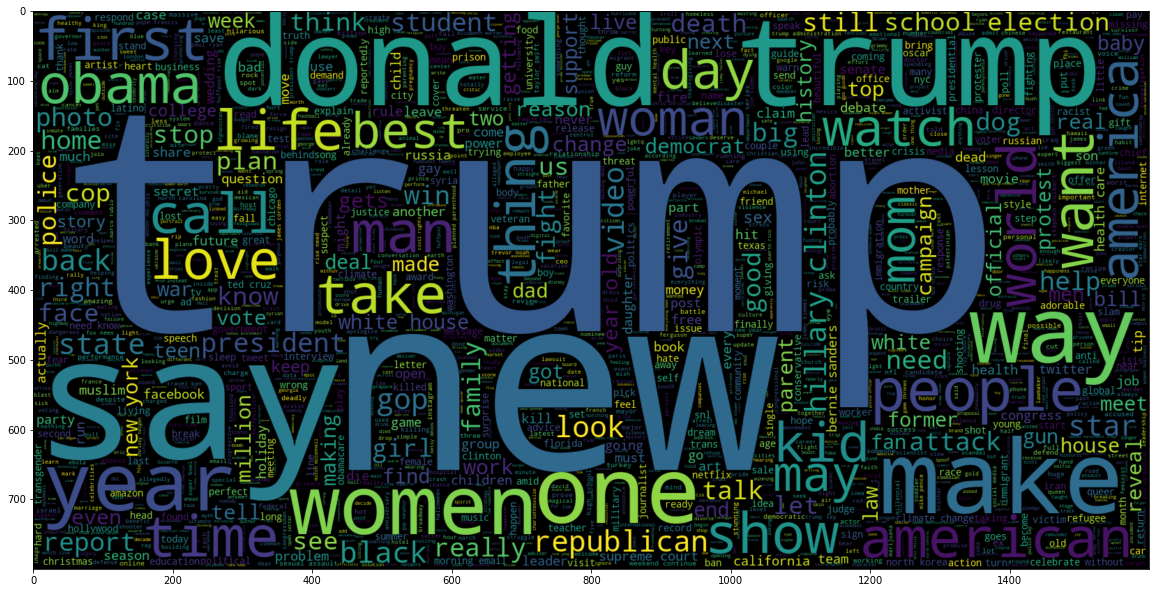

In [ ]:

plt.figure(figsize = (20,20)) #fig size
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df2[df2['is_sarcastic'] == 0]['headline_new'])) #News that is Not Sarcastic
plt.imshow(wc , interpolation = 'bilinear')

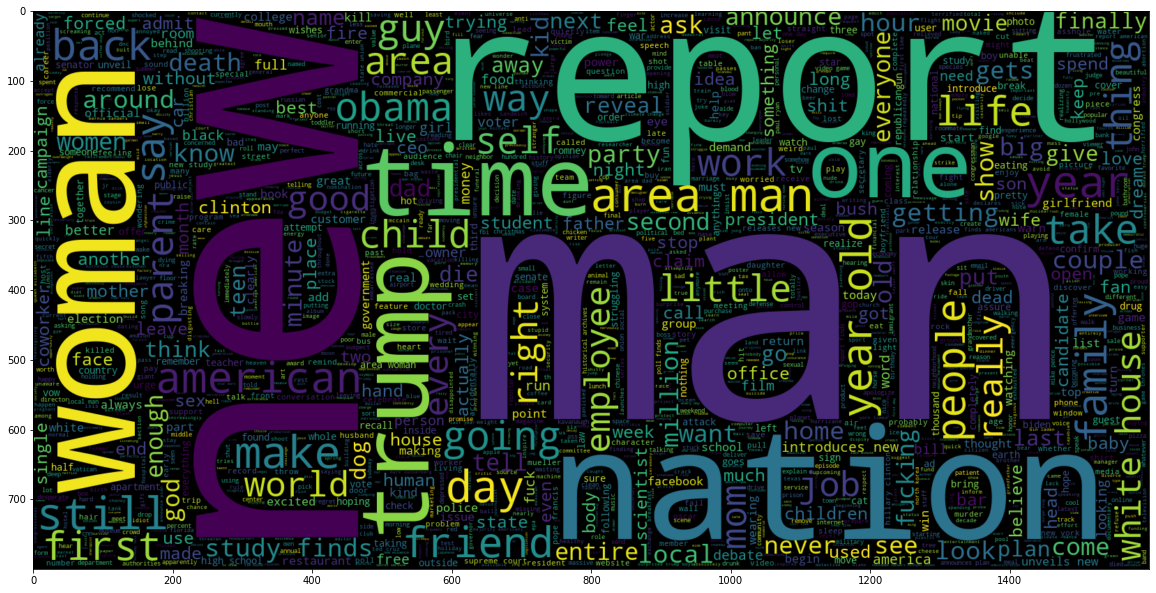

In [ ]:
plt.figure(figsize = (20,20)) #fig size
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df2[df2['is_sarcastic'] == 1]['headline_new'])) #News that is Sarcastic
plt.imshow(wc , interpolation = 'bilinear')

length of each headline ?

In [ ]:
len_not_sarcastic = df2[df2['is_sarcastic']==0]['headline_new'].str.len() #find length of headline (all characters including spaces)
len_sarcastic = df2[df2['is_sarcastic']==1]['headline_new'].str.len()

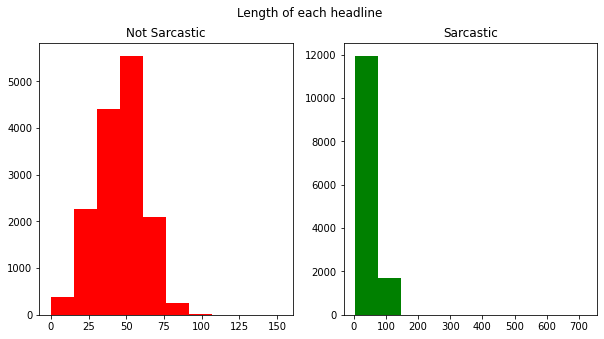

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5)) #subplots to plot side by side

ax1.hist(len_not_sarcastic,color='red')
ax1.set_title('Not Sarcastic')

ax2.hist(len_sarcastic,color='green')
ax2.set_title('Sarcastic')

fig.suptitle('Length of each headline')
plt.show()

no. of words in each headline ?

In [ ]:
count_not_sarcastic = df2[df2['is_sarcastic']==0]['headline_new'].str.split() #split headline into words
cns=count_not_sarcastic.map(lambda x: len(x)) #find no. of words in a headline

count_sarcastic = df2[df2['is_sarcastic']==1]['headline_new'].str.split()
cs=count_sarcastic.map(lambda x: len(x))

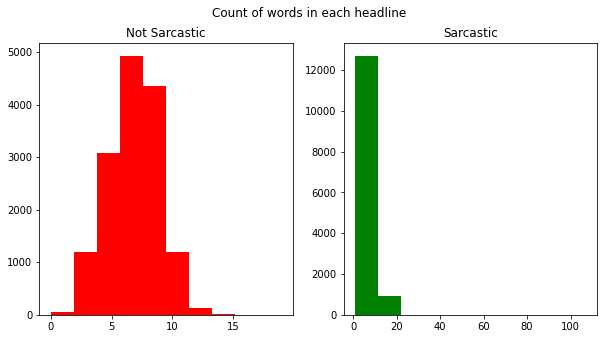

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5)) #subplots to plot side by side

ax1.hist(cns,color='red')
ax1.set_title('Not Sarcastic')

ax2.hist(cs,color='green')
ax2.set_title('Sarcastic')

fig.suptitle('Count of words in each headline')
plt.show() 

sarcastic headlines are much longer and have more words

average word length in a headline ?

In [ ]:
avg_not_sarcastic = df2[df2['is_sarcastic']==0]['headline_new'].map(lambda x: [len(i) for i in x.split()]) #length of each word in a news headline
ansc=avg_not_sarcastic.map(lambda x: np.mean(x)) #mean of those lengths

avg_sarcastic = df2[df2['is_sarcastic']==1]['headline_new'].map(lambda x: [len(i) for i in x.split()])
asc=avg_sarcastic.map(lambda x: np.mean(x)) 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


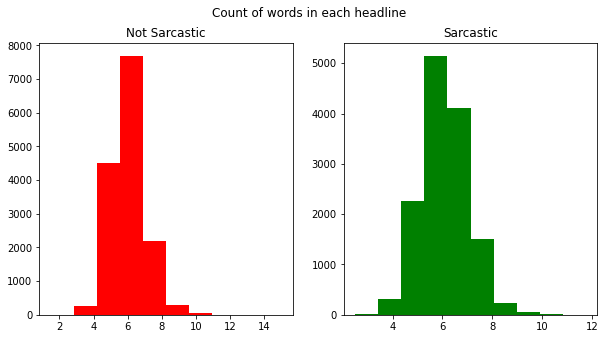

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5)) #subplots to plot side by side

ax1.hist(ansc,color='red')
ax1.set_title('Not Sarcastic')

ax2.hist(asc,color='green')
ax2.set_title('Sarcastic')

fig.suptitle('Count of words in each headline')
plt.show() 

#Tokenize

In [ ]:
embedding_dim = 100
max_length = 20 #20 words per headline max
trunc_type = 'post'
pad_type = 'post'
training_size = len(df2)
test_portion = 0.3
training_size

28619

In [ ]:
tokenizer = Tokenizer() #create tokenizer object 
tokenizer.fit_on_texts(df2['headline_new']) #create word index dict

word_index_dict = tokenizer.word_index #get word index dict
vocab_size = len(word_index_dict) + 1

vocab_size

25766

In [ ]:
sequence = tokenizer.texts_to_sequences(df2['headline_new']) #convert words to their vector representations

padding = pad_sequences(sequences=sequence, maxlen=max_length, padding=pad_type, truncating=trunc_type) #pad all sequences, to ensure same length

split = int(test_portion*training_size)
split

8585

#Split train test instances

In [ ]:
test_sequences = padding[0:split] 
training_sequences = padding[split:]

labels = df2['is_sarcastic']
test_labels = labels[0:split]
training_labels = labels[split:]

#Load GloVe 100-D

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-08-02 17:03:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 173.194.79.128, 108.177.96.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  57.9MB/s    in 5.7s    

2020-08-02 17:04:06 (57.9 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
embedding_dict = {} #create embedding dict with words and their 100-D representations

with open('/tmp/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float64')
    embedding_dict[word] = coefs
  

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim)) #create embedding matrix to store weights
embedding_matrix.shape

(25766, 100)

In [ ]:
for word, index in word_index_dict.items(): #update embeddings matrix with their GloVe 100-D weights
  embedding_vector = embedding_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
test_sequences = np.asarray(test_sequences, dtype='int64') #covert to array
training_sequences = np.asarray(training_sequences, dtype='int64')

test_labels = np.asarray(test_labels)
training_labels = np.asarray(training_labels)

#Build RNN Model with LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False), #we don't want to update/change the learned weights
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.4, return_sequences=False)), #using LSTM gate to overcome vanishing Gradient problem due to long term dependancies
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           2576600   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,661,209
Trainable params: 84,609
Non-trainable params: 2,576,600
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics='accuracy')

#Fit model on training. 
Find when to stop training and set stopping rounds.

In [ ]:
num_epochs = 10
history = model.fit(x=training_sequences, y=training_labels, validation_data=(test_sequences, test_labels), epochs = num_epochs, verbose = 1)


Epoch 1/10
627/627 [==============================] - 6s 9ms/step - loss: 0.5522 - accuracy: 0.7123 - val_loss: 0.4970 - val_accuracy: 0.7591
Epoch 2/10
627/627 [==============================] - 5s 8ms/step - loss: 0.4803 - accuracy: 0.7674 - val_loss: 0.4458 - val_accuracy: 0.7880
Epoch 3/10
627/627 [==============================] - 5s 8ms/step - loss: 0.4410 - accuracy: 0.7933 - val_loss: 0.4649 - val_accuracy: 0.7800
Epoch 4/10
627/627 [==============================] - 5s 8ms/step - loss: 0.4176 - accuracy: 0.8051 - val_loss: 0.4129 - val_accuracy: 0.8096
Epoch 5/10
627/627 [==============================] - 5s 8ms/step - loss: 0.3944 - accuracy: 0.8164 - val_loss: 0.4084 - val_accuracy: 0.8134
Epoch 6/10
627/627 [==============================] - 5s 8ms/step - loss: 0.3784 - accuracy: 0.8272 - val_loss: 0.4179 - val_accuracy: 0.8086
Epoch 7/10
627/627 [==============================] - 5s 8ms/step - loss: 0.3622 - accuracy: 0.8373 - val_loss: 0.3981 - val_accuracy: 0.8241
Epoch 

#Visualize Metrics

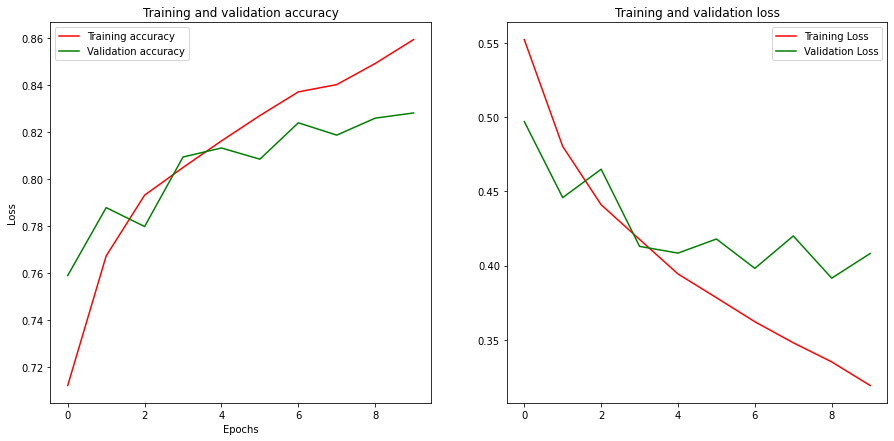

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [i for i in range(10)]

fig, ax = plt.subplots(1,2)

ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

fig.set_size_inches(15,7)
plt.show()

stop training after 4 iterations, to avoid overfitting & improve generalization performance

In [ ]:
num_epochs = 4
history = model.fit(x=training_sequences, y=training_labels, validation_data=(test_sequences, test_labels), epochs = num_epochs, verbose = 1)


Epoch 1/4
627/627 [==============================] - 5s 8ms/step - loss: 0.3137 - accuracy: 0.8615 - val_loss: 0.4244 - val_accuracy: 0.8202
Epoch 2/4
627/627 [==============================] - 5s 8ms/step - loss: 0.3044 - accuracy: 0.8660 - val_loss: 0.3951 - val_accuracy: 0.8277
Epoch 3/4
627/627 [==============================] - 5s 8ms/step - loss: 0.2958 - accuracy: 0.8715 - val_loss: 0.3989 - val_accuracy: 0.8274
Epoch 4/4
627/627 [==============================] - 5s 8ms/step - loss: 0.2914 - accuracy: 0.8728 - val_loss: 0.4105 - val_accuracy: 0.8284


#Evaluate accuracy and loss on test data

In [ ]:
print("Training Loss and Accuracy: ")
loss, accuracy = model.evaluate(training_sequences, training_labels, verbose = 1)
print("Validation Loss and Accuracy: ")
loss, accuracy = model.evaluate(test_sequences, test_labels, verbose = 1)

Training Loss and Accuracy: 
627/627 [==============================] - 2s 4ms/step - loss: 0.1712 - accuracy: 0.9360
Validation Loss and Accuracy: 
269/269 [==============================] - 1s 4ms/step - loss: 0.4105 - accuracy: 0.8284
